In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)
og_df = df.copy()
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
420527,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
420533,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
420539,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7


In [4]:
# parsing wv (m/s)
wv = df['wv (m/s)']

# parsing bad_wv index
bad_wv = wv == -9999.0

# replace zero value
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

In [5]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

Text(0.5, 1.0, 'Time of day signal')

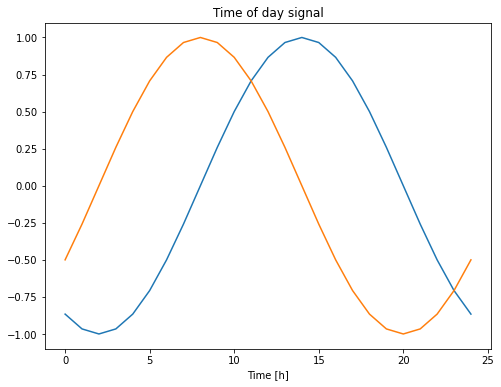

In [6]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

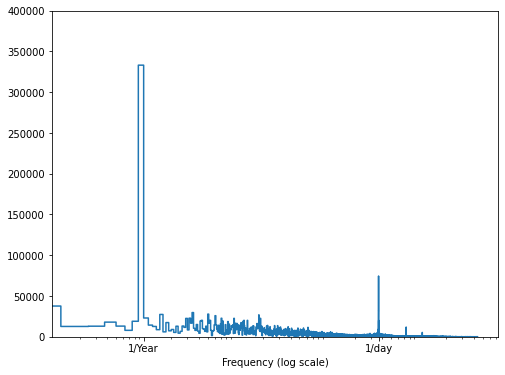

In [7]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

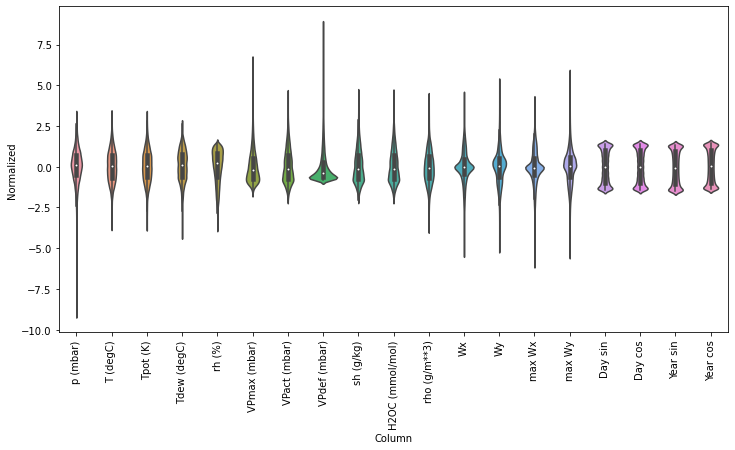

In [10]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [11]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [12]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [13]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [14]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [15]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [16]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [38]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [39]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

In [40]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

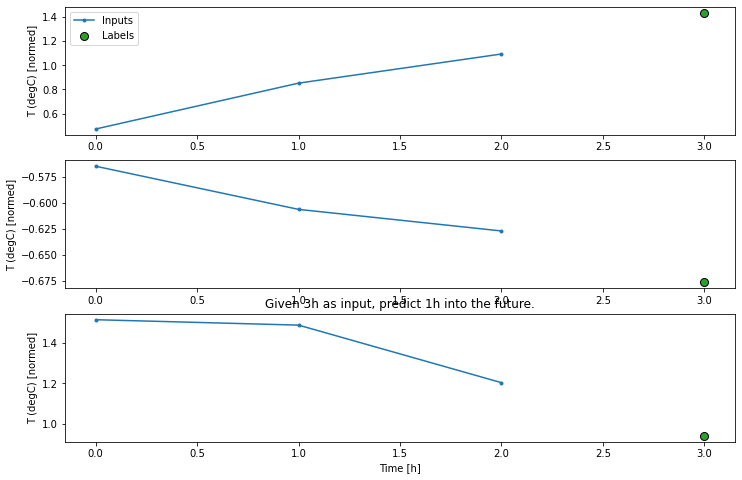

In [41]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [42]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [43]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [44]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()

val_performance = {}
performance = {}

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 0s 895us/step - loss: 0.0069 - mean_absolute_error: 0.0579


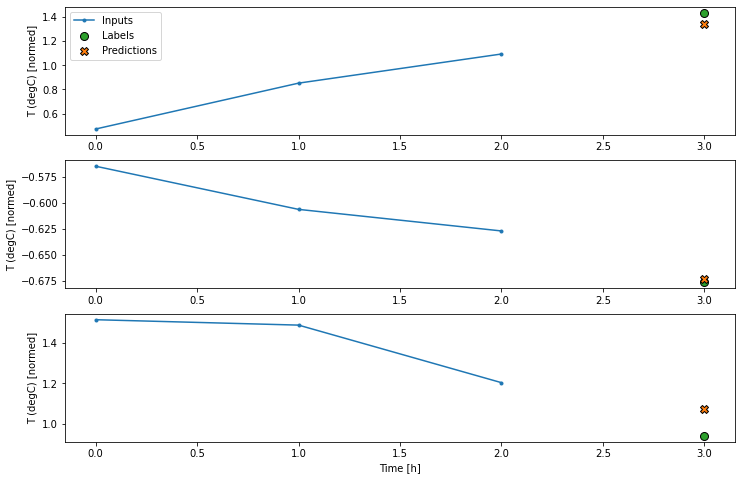

In [45]:
conv_window.plot(multi_step_dense)

In [46]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Input 0 of layer dense_9 is incompatible with the layer: expected axis -1 of input shape to have value 57 but received input with shape (32, 456)
